# NN Regression on Franke Function using Pytorch 

#### Import libraries

In [1]:
import sys
import os

# Add the 'src' directory to the Python path
src_dir = os.path.join(os.path.dirname(os.getcwd()), 'src')
sys.path.append(src_dir)

In [2]:
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from torch import nn, optim, tensor
from Neural_Network_with_PyTorch import Neural_Network_PyTorch

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import linear_model

from tqdm import tqdm
from copy import deepcopy

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

## Create Data

In [3]:
def FrankeFunction(x,y):
    
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [4]:
N = 1000
x = np.random.uniform(0, 1, N)
y = np.random.uniform(0, 1, N)

# Franke function with added noise:
z = FrankeFunction(x, y) + np.random.normal(0, 0.1, x.shape)
target = torch.tensor(z).reshape(len(z), 1).float()

# Making the design matrix:
X = torch.from_numpy(np.stack((x, y), axis=-1)).float()

# Splitting the data into training and test set:
test_size = 0.2
X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=test_size)

## Tune model using K-fold cross validation

In [5]:
def train_with_crossval(train_X, train_target, 
                        n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                        activation_hidden, 
                        learning_rate, l2_reg, 
                        num_epochs, n_minibatches):
    torch.manual_seed(1234)
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    # Initialize the evaluation metrices
    mse_crossval = []
    r2_crossval = []
    mse_train_crossval = []
    r2_train_crossval = []
    # Loop over the folds
    for train_idx, val_idx in kf.split(train_X):
        # Extract training and validation data
        X_train, target_train = train_X[train_idx], train_target[train_idx]
        X_val, target_val = train_X[val_idx], train_target[val_idx]
        
        # Create new network
        ffnn = Neural_Network_PyTorch(n_features, 
                                      n_hidden_layers, n_hidden_nodes, 
                                      n_outputs, 
                                      activation_function_hidden_layers=activation_hidden, 
                                      activation_function_output_layer=None)
        
        # Loss function
        criterion = nn.MSELoss()
        # Optimizer
        optimizer = optim.Adam(ffnn.parameters(), lr=learning_rate, weight_decay=l2_reg)
        
        # Train the network            
        ffnn = ffnn.train_network(X_train, target_train, 
                                  optimizer, criterion,
                                  num_iter=num_epochs, n_minibatches=n_minibatches)
        # Evaluate the network
        # Train performance
        target_train_pred = ffnn.feed_forward(X_train)
        mse_train_crossval.append(float(criterion(target_train_pred, target_train)))
        r2_train_crossval.append(r2_score(target_train, target_train_pred.detach().numpy()))
        # Validation performance
        ffnn.eval() # set model in evaluation mode
        with torch.no_grad(): # disable gradient computation
            target_val_pred = ffnn.feed_forward(X_val)
            mse_val_cv = float(criterion(target_val_pred, target_val))
            mse_crossval.append(mse_val_cv)
            r2_crossval.append(r2_score(target_val, target_val_pred))
    
    return ffnn, mse_crossval, r2_crossval, mse_train_crossval, r2_train_crossval

### Initial tuning of learning rate

Define model

In [78]:
n_hidden_layers = 2
n_hidden_nodes = 8
n_outputs = 1
n_features = X_train.shape[1]
activation_hidden = "sigmoid"
learning_rate_space = np.logspace(-4, 0, 5)
lmbd = 0.0001
n_epochs = 100
n_minibatches = 16

In [79]:
# Initialize the evaluation metrices
mse = np.zeros((len(learning_rate_space), 1))
r2 = np.zeros((len(learning_rate_space), 1))
mse_train = np.zeros((len(learning_rate_space), 1))
r2_train = np.zeros((len(learning_rate_space), 1))
for i, learning_rate in enumerate(learning_rate_space):
    print(f"Learning rate: {learning_rate}")

    (ffnn, 
    mse_crossval, 
    r2_crossval, 
    mse_train_crossval, 
    r2_train_crossval) = train_with_crossval(X_train, target_train, 
                        n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                        activation_hidden, 
                        learning_rate, lmbd, 
                        n_epochs, n_minibatches)
    
    mse[i][0] = np.mean(mse_crossval)
    r2[i][0] = np.mean(r2_crossval)
    mse_train[i][0] = np.mean(mse_train_crossval)
    r2_train[i][0] = np.mean(r2_train_crossval)

Learning rate: 0.0001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB2CDE0B80>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396DAAC0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396DBB00>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396DA980>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396DAAC0>
Learning rate: 0.001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396D87C0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB2CDE0B80>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396DAFC0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396DB240>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB2CDE0B80>
Learnin

In [101]:
best_r2 = np.max(r2)
best_mse = np.min(mse)
best_r2_idx = np.argmax(r2)
best_mse_idx = np.argmin(mse)
print(f"Best R2: {best_r2:.4f} yielded by best learning rate: {learning_rate_space[best_r2_idx]}")
print(f"Best MSE: {best_mse:.4f} yielded by best learning rate: {learning_rate_space[best_mse_idx]}")

IndexError: index 7 is out of bounds for axis 0 with size 5

We keep the best learning rate and tune the rest of the hyperparameters. We will retune the learning rate at the end.

### Tune epochs and minibatches

In [82]:
n_hidden_layers = 2
n_hidden_nodes = 8
n_outputs = 1
n_features = X_train.shape[1]
activation_hidden = "sigmoid"
learning_rate = 0.01
lmbd = 0.0001
n_epochs_space = [50, 100, 150]
n_minibatches_space = [8, 16, 32, 64]

In [98]:
# Initialize the evaluation metrices
mse = np.zeros((len(n_epochs_space), len(n_minibatches_space)))
r2 = np.zeros((len(n_epochs_space), len(n_minibatches_space)))
mse_train = np.zeros((len(n_epochs_space), len(n_minibatches_space)))
r2_train = np.zeros((len(n_epochs_space), len(n_minibatches_space)))

for i, n_epochs in enumerate(n_epochs_space):
    print(f"Number of epochs: {n_epochs}")
    for j, n_minibatches in enumerate(n_minibatches_space):
        print(f"Number of minibatches: {n_minibatches}")
        (ffnn, 
        mse_crossval, 
        r2_crossval, 
        mse_train_crossval, 
        r2_train_crossval) = train_with_crossval(X_train, target_train, 
                            n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                            activation_hidden, 
                            learning_rate, lmbd, 
                            n_epochs, n_minibatches)
       
        mse[i][j] = np.mean(mse_crossval)
        r2[i][j] = np.mean(r2_crossval)
        mse_train[i][j] = np.mean(mse_train_crossval)
        r2_train[i][j] = np.mean(r2_train_crossval)

Number of epochs: 50
Number of minibatches: 8
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396DA3E0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396D9440>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396DA020>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396DA3E0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396D9440>
Number of minibatches: 16
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396D8CC0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396DAD40>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396DADE0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396D8CC0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy a

In [102]:
best_r2 = np.max(r2)
best_mse = np.min(mse)
best_r2_idx = np.where(r2==best_r2)
best_mse_idx = np.where(mse==best_mse)
print(f"Best R2: {best_r2:.4f} yielded by best epochs: {n_epochs_space[best_r2_idx[0][0]]}"
      f" and best n minibatches: {n_minibatches_space[best_r2_idx[1][0]]}")
print(f"Best MSE: {best_mse:.4f} yielded by best epochs: {n_epochs_space[best_mse_idx[0][0]]}"
      f" and best n minibatches: {n_minibatches_space[best_mse_idx[1][0]]}")
print(r2)
print(mse)

Best R2: 0.6792 yielded by best epochs: 100 and best n minibatches: 64
Best MSE: 0.0313 yielded by best epochs: 100 and best n minibatches: 64
[[0.46331089 0.61874213 0.60940904 0.66697077]
 [0.62580059 0.63199284 0.66741864 0.67918744]
 [0.64338223 0.63534931 0.60901974 0.66840931]]
[[0.0538846  0.03751198 0.03779448 0.03294351]
 [0.03691274 0.03561857 0.03271436 0.03127981]
 [0.03503192 0.03575732 0.03858674 0.03243506]]


We will now keep the epochs at: 100, and number of minibatches as: 64  

### Tuning number of hidden layers and hidden nodes

In [105]:
n_hidden_layers_space = [2, 3, 4]
n_hidden_nodes_space = [2, 6, 10]
n_outputs = 1
n_features = X_train.shape[1]
activation_hidden = "sigmoid"
learning_rate = 0.01
lmbd = 0.0001
n_epochs = 100
n_minibatches = 64

In [107]:
# Initialize the evaluation metrices
mse = np.zeros((len(n_hidden_layers_space), len(n_hidden_nodes_space)))
r2 = np.zeros((len(n_hidden_layers_space), len(n_hidden_nodes_space)))
mse_train = np.zeros((len(n_hidden_layers_space), len(n_hidden_nodes_space)))
r2_train = np.zeros((len(n_hidden_layers_space), len(n_hidden_nodes_space)))

for i, n_hidden_layers in enumerate(n_hidden_layers_space):
    print(f"Number of hidden layers: {n_hidden_layers}")
    for j, n_hidden_nodes in enumerate(n_hidden_nodes_space):
        print(f"Number of hidden nodes: {n_hidden_nodes}")
        (ffnn, 
        mse_crossval, 
        r2_crossval, 
        mse_train_crossval, 
        r2_train_crossval) = train_with_crossval(X_train, target_train, 
                            n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                            activation_hidden, 
                            learning_rate, lmbd, 
                            n_epochs, n_minibatches)
       
        mse[i][j] = np.mean(mse_crossval)
        r2[i][j] = np.mean(r2_crossval)
        mse_train[i][j] = np.mean(mse_train_crossval)
        r2_train[i][j] = np.mean(r2_train_crossval)

Number of hidden layers: 2
Number of hidden nodes: 2
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396D8F40>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB3956AC00>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396DA3E0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB396D8F40>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB3956AC00>
Number of hidden nodes: 6
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB39998CC0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB37715C60>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB39998CC0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001AB37715300>
<function Neural_Network_PyTorch.set_activation_function.<locals>.

In [114]:
best_r2 = np.max(r2)
best_mse = np.min(mse)
best_r2_idx = np.where(r2==best_r2)
print(best_r2_idx)
best_mse_idx = np.where(mse==best_mse)
print(f"Best R2: {best_r2:.4f} yielded by best hidden layer count: {n_hidden_layers_space[best_r2_idx[0][0]]}"
      f" and best number of hidden nodes: {n_hidden_nodes_space[best_r2_idx[1][0]]}")
print(f"Best MSE: {best_mse:.4f} yielded by best hidden layer count: {n_hidden_layers_space[best_mse_idx[0][0]]}"
      f" and best number of hidden nodes: {n_hidden_nodes_space[best_mse_idx[1][0]]}")
print(r2)
print(mse)

(array([1], dtype=int64), array([0], dtype=int64))
Best R2: 0.6817 yielded by best hidden layer count: 3 and best number of hidden nodes: 2
Best MSE: 0.0312 yielded by best hidden layer count: 3 and best number of hidden nodes: 2
[[ 0.66390218  0.67138998  0.65562207]
 [ 0.68166277  0.67865071  0.60249315]
 [-0.03902513 -0.01048507  0.09626575]]
[[0.03327006 0.0319664  0.0336294 ]
 [0.03120069 0.03137239 0.03765763]
 [0.10192578 0.0990309  0.08936345]]


We keep the number of hidden layers at: 3, and the number of nodes per layer at: 2. 

### Tuning lambda and learning rate for different activation functions

In [6]:
n_hidden_layers = 3
n_hidden_nodes = 2
n_outputs = 1
n_features = X_train.shape[1]
activation_hidden_space = ["sigmoid", 'tanh', 'ReLU', 'Leaky ReLU']  
learning_rate_space = np.logspace(-4, 0, 5)
lmbd_space = np.insert(np.logspace(-5, -2, 4), -1, 0.0)
n_epochs = 100
n_minibatches = 64

In [7]:
# Initialize the evaluation metrices
d = {}
for activation_hidden in activation_hidden_space:
    print(f'Activation function hidden layers: {activation_hidden}')
    
    mse = np.zeros((len(learning_rate_space), len(lmbd_space)))
    r2 = np.zeros((len(learning_rate_space), len(lmbd_space)))
    mse_train = np.zeros((len(learning_rate_space), len(lmbd_space)))
    r2_train = np.zeros((len(learning_rate_space), len(lmbd_space)))
    
    for i, learning_rate in enumerate(learning_rate_space):
        print(f"Learning_rate: {learning_rate}")
        for j, lmbd in enumerate(lmbd_space):
            print(f"L2 regularization term: {lmbd}")
            (ffnn, 
            mse_crossval, 
            r2_crossval, 
            mse_train_crossval, 
            r2_train_crossval) = train_with_crossval(X_train, target_train, 
                                n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                activation_hidden, 
                                learning_rate, lmbd, 
                                n_epochs, n_minibatches)
           
            mse[i][j] = np.mean(mse_crossval)
            r2[i][j] = np.mean(r2_crossval)
            mse_train[i][j] = np.mean(mse_train_crossval)
            r2_train[i][j] = np.mean(r2_train_crossval)
            
    d[activation_hidden] = [mse, r2, mse_train, r2_train]

Activation function hidden layers: sigmoid
Learning_rate: 0.0001
L2 regularization term: 1e-05
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001394C4EFE20>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D64D0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A865990>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D6560>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001394C4EFE20>
L2 regularization term: 0.0001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D6560>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A865990>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACC9E10>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D64D0>
<function Neural_Ne

L2 regularization term: 0.0001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001394C4EFE20>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACC9F30>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D64D0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A865990>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001394C4EFE20>
L2 regularization term: 0.001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A865990>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D64D0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACC9F30>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D6560>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000013

<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001394C4EFE20>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACC9E10>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D6560>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A865990>
L2 regularization term: 0.0
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D6560>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACC9F30>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001394C4EFE20>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D64D0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D6560>
L2 regularization term: 0.01
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4

<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D64D0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001394C4EFE20>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D6560>
L2 regularization term: 0.01
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001394C4EFE20>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D64D0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACCA050>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A865990>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001394C4EFE20>
Activation function hidden layers: ReLU
Learning_rate: 0.0001
L2 regularization term: 1e-05
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A865990>
<function Neural_Network

<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A865990>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACCA0E0>
Learning_rate: 0.1
L2 regularization term: 1e-05
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A865990>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001394C4EFE20>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACC9F30>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A865990>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACC9F30>
L2 regularization term: 0.0001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A865990>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D6560>
<function Neural_Network_PyTorch.set_activation_function.<locals>

<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACCA170>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D6560>
L2 regularization term: 0.0001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001394C4EFE20>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACCA0E0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A865990>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACC9F30>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001394C4EFE20>
L2 regularization term: 0.001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D6560>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A865990>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000013

<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACCA0E0>
L2 regularization term: 0.001
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A865990>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACCA050>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACC9F30>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D6560>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A865990>
L2 regularization term: 0.0
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A4D6560>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACCA170>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACCA0E0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395A

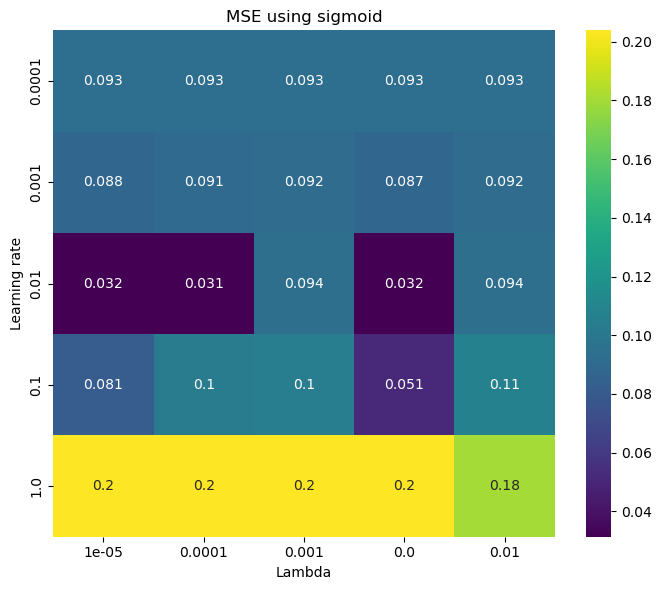

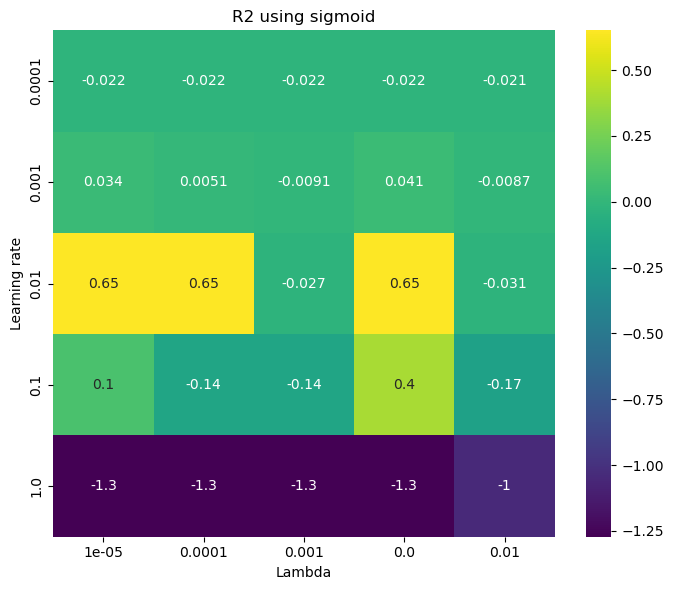

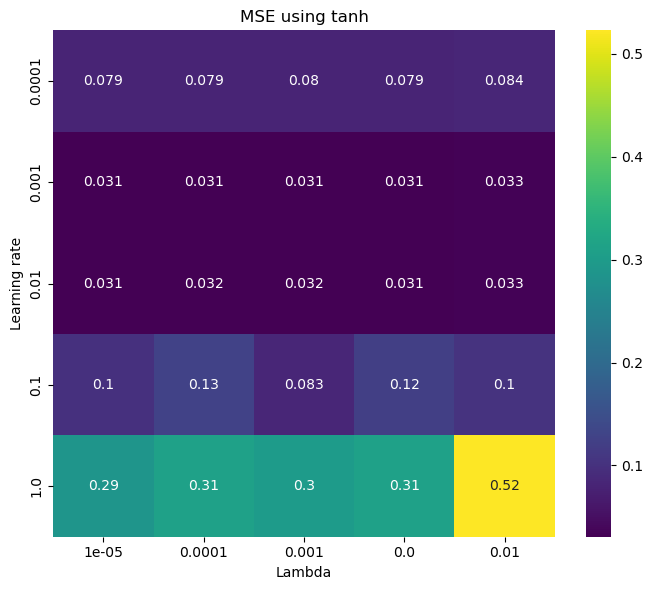

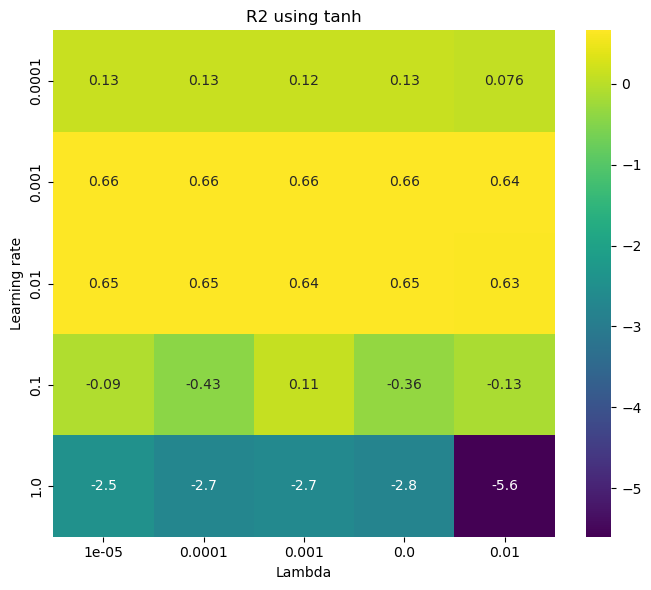

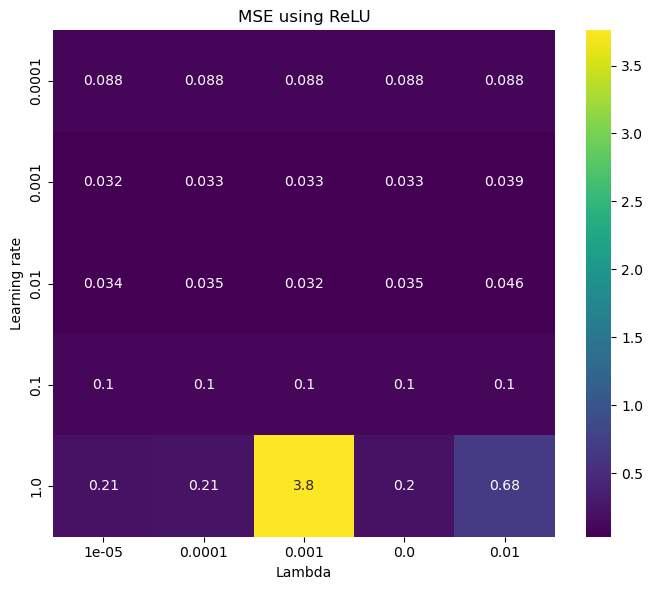

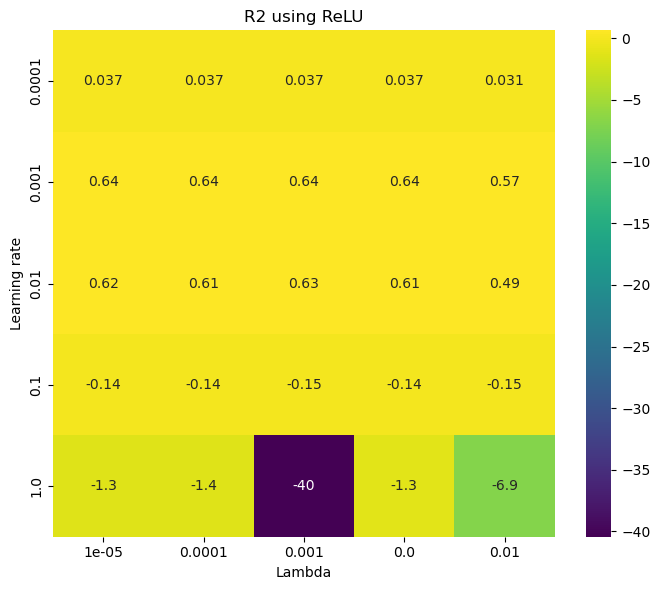

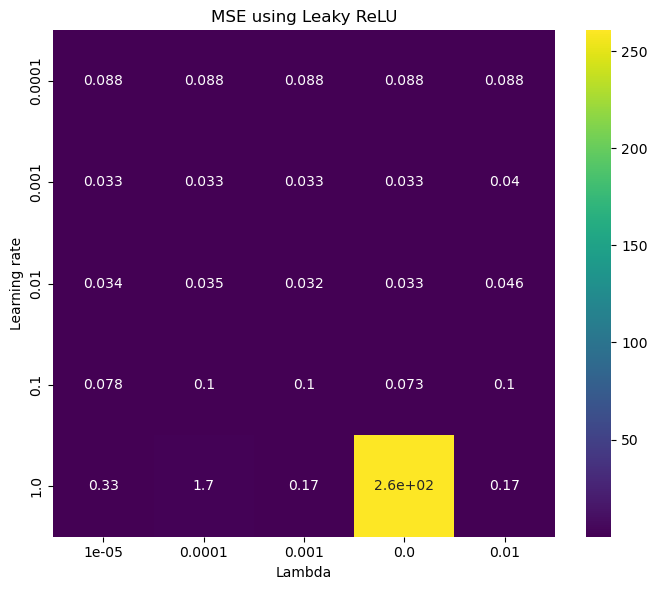

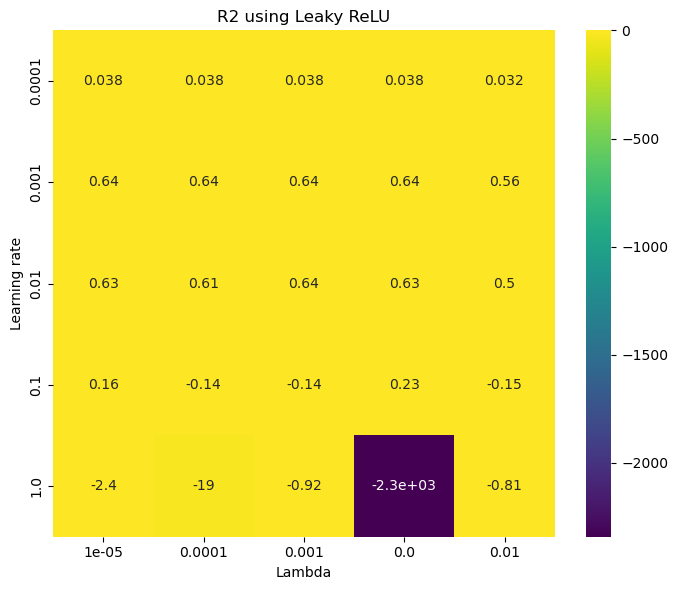

In [10]:
 for activation_hidden, performance_metrix in d.items():
    mse = performance_metrix[0]
    r2 = performance_metrix[1]

    fig, ax = plt.subplots(figsize = (7, 6))
    heatmap = sns.heatmap(mse, annot=True, ax=ax, cmap="viridis")
    heatmap.set_xticklabels(lmbd_space)
    heatmap.set_yticklabels(learning_rate_space)
    ax.set_title(f"MSE using {activation_hidden}")
    ax.set_ylabel('Learning rate')
    ax.set_xlabel('Lambda')
    plt.tight_layout()
    plt.savefig(rf"Figures\Task_b\Franke_tune_lambda_and_lr_pythorch_{activation_hidden}_MSE.png")
    plt.show()

    fig, ax = plt.subplots(figsize = (7, 6))
    heatmap = sns.heatmap(r2, annot=True, ax=ax, cmap="viridis")
    heatmap.set_xticklabels(lmbd_space)
    heatmap.set_yticklabels(learning_rate_space)
    ax.set_title(f"R2 using {activation_hidden}")
    ax.set_ylabel('Learning rate')
    ax.set_xlabel('Lambda')
    plt.tight_layout()
    plt.savefig(rf"Figures\Task_b\Franke_tune_lambda_and_lr_pythorch_{activation_hidden}_R2.png")
    plt.show()

In [11]:
for activation_hidden, performance_metrix in d.items():
    mse = performance_metrix[0]
    r2 = performance_metrix[1]
    mse_train = performance_metrix[2]
    r2_train = performance_metrix[3]
    
    best_r2 = np.max(r2)
    best_mse = np.min(mse)
    best_r2_idx = np.where(r2==best_r2)
    best_mse_idx = np.where(mse==best_mse)
    print(f'\n #### For {activation_hidden} #### \n')
    print(f"Best R2: {best_r2:.4f} yielded by learning rate: {learning_rate_space[best_r2_idx[0][0]]}"
          f" and best l2 regulariztion : {lmbd_space[best_r2_idx[1][0]]}")
    print(f"Best MSE: {best_mse:.4f} yielded by best learning rate: {learning_rate_space[best_mse_idx[0][0]]}"
          f" and best l2 regulariztion: {lmbd_space[best_mse_idx[1][0]]}")
    print(r2)
    print(mse)


 #### For sigmoid #### 

Best R2: 0.6509 yielded by learning rate: 0.01 and best l2 regulariztion : 0.0001
Best MSE: 0.0313 yielded by best learning rate: 0.01 and best l2 regulariztion: 0.0001
[[-0.0216057  -0.02162197 -0.02189725 -0.02160437 -0.02052092]
 [ 0.03409488  0.00508083 -0.00909237  0.04117821 -0.00871772]
 [ 0.64815072  0.65091876 -0.02702021  0.64687966 -0.03111072]
 [ 0.10256319 -0.14330204 -0.14379071  0.40093108 -0.17175451]
 [-1.27190204 -1.26866299 -1.27122192 -1.27108343 -1.04665259]]
[[0.09286964 0.09287168 0.09289959 0.09286944 0.09279357]
 [0.08795878 0.09062279 0.09192255 0.08730927 0.09189025]
 [0.03158916 0.0313112  0.09358081 0.03171132 0.09396936]
 [0.08123029 0.10337753 0.10390132 0.05113932 0.10635008]
 [0.20390729 0.20383286 0.20374694 0.20382609 0.18079841]]

 #### For tanh #### 

Best R2: 0.6599 yielded by learning rate: 0.001 and best l2 regulariztion : 0.0
Best MSE: 0.0307 yielded by best learning rate: 0.001 and best l2 regulariztion: 0.0
[[ 0.12966

We will continue with tanh activation function, 0.001 learning rate and lmbd value 0.0

## Retrain model on entire training set and estimate generalization error

In [12]:
N = 1000
x = np.random.uniform(0, 1, N)
y = np.random.uniform(0, 1, N)

# Franke function with added noise:
z = FrankeFunction(x, y) + np.random.normal(0, 0.1, x.shape)
target = torch.tensor(z).reshape(len(z), 1).float()

# Making the design matrix:
X = torch.from_numpy(np.stack((x, y), axis=-1)).float()

In [13]:
n_hidden_layers = 3
n_hidden_nodes = 2
n_outputs = 1
n_features = X_train.shape[1]
activation_hidden_space = 'tanh'  
learning_rate = .001
lmbd = .00
n_epochs = 100
n_minibatches = 64

In [14]:
np.random.seed(seed)
torch.manual_seed(seed)

(ffnn, 
mse_test_crossval, 
r2_test_crossval, 
mse_train_crossval, 
r2_train_crossval) = train_with_crossval(X, target, 
                                         n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                         activation_hidden, 
                                         learning_rate, lmbd, 
                                         n_epochs, n_minibatches)
# Evaluate the network
# Train performance
mse_train = np.mean(mse_train_crossval)
r2_train = np.mean(r2_train_crossval)
mse_test = np.mean(mse_test_crossval)
r2_test = np.mean(r2_test_crossval)

<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395D5737F0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395D23BD90>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACCA0E0>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395ACCA200>
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x000001395D5737F0>


In [15]:
print(f'training: mse = {mse_train}, R2 = {r2_train}')
print(f'test:     mse = {mse_test}, R2 = {r2_test}')      

training: mse = 0.022375494614243506, R2 = 0.7740398870333017
test:     mse = 0.023278598114848136, R2 = 0.7576937329517925


It can seem that we have overfitted the model at some level, we might have chived higher generalization performance using further regularization terms. 